
# 📧 Email Marketing Campaign Case Study

This notebook analyzes an email marketing campaign, builds a model to optimize click-through rates, and visualizes insights from the data.



## Load the Data

Three CSV files are given:
- `email_table.csv`: Metadata about sent emails
- `email_opened_table.csv`: IDs of emails that were opened
- `link_clicked_table.csv`: IDs of emails whose links were clicked


In [1]:
import numpy as np
import pandas as pd

# Load data
email_table = pd.read_csv('email_table.csv')
email_opened = pd.read_csv('email_opened_table.csv')
link_clicked = pd.read_csv('link_clicked_table.csv')

email_table.head()


,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases
0,85120,short_email,personalized,2,Sunday,US,5
1,966622,long_email,personalized,12,Sunday,UK,2
2,777221,long_email,personalized,11,Wednesday,US,2
3,493711,short_email,generic,6,Monday,UK,1
4,106887,long_email,generic,14,Monday,US,6



## Calculate Email Open and Click-Through Rates


In [3]:

# Total emails sent
total_emails = email_table.shape[0]

# Open and click counts
opened_emails = email_opened['email_id'].nunique()
clicked_emails = link_clicked['email_id'].nunique()

# Rates
open_rate = opened_emails / total_emails
click_through_rate = clicked_emails / total_emails 

print(f"Open Rate: {open_rate:.2%}")
print(f"Click-Through Rate: {click_through_rate:.2%}")


Open Rate: 10.35%
Click-Through Rate: 2.12%



## Data Preprocessing

- The tables are used and categorical variables are encoded to prepare for modeling.
- Here LabelEncoder is used for encoding categorical features.

In [6]:

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Merge labels
email_table['opened'] = email_table['email_id'].isin(email_opened['email_id']).astype(int)
email_table['clicked'] = email_table['email_id'].isin(link_clicked['email_id']).astype(int)

# Encode categorical columns
df = email_table.copy()
temp_df = df.copy()  ## This is used to identify what class name is labelled to each class for every categorical feature.

categorical_cols = ['email_text', 'email_version', 'weekday', 'user_country']
df[categorical_cols] = df[categorical_cols].apply(LabelEncoder().fit_transform)



In [7]:
df

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,opened,clicked
0,85120,1,1,2,3,3,5,0,0
1,966622,0,1,12,3,2,2,1,1
2,777221,0,1,11,6,3,2,0,0
3,493711,1,0,6,1,2,1,0,0
4,106887,0,0,14,1,3,6,0,0
...,...,...,...,...,...,...,...,...,...
99995,803504,1,1,4,1,3,5,0,0
99996,899722,0,1,7,2,3,1,0,0
99997,449610,0,1,11,2,2,6,0,0
99998,72497,1,0,10,1,2,0,0,0


In [8]:
temp_df

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,opened,clicked
0,85120,short_email,personalized,2,Sunday,US,5,0,0
1,966622,long_email,personalized,12,Sunday,UK,2,1,1
2,777221,long_email,personalized,11,Wednesday,US,2,0,0
3,493711,short_email,generic,6,Monday,UK,1,0,0
4,106887,long_email,generic,14,Monday,US,6,0,0
...,...,...,...,...,...,...,...,...,...
99995,803504,short_email,personalized,4,Monday,US,5,0,0
99996,899722,long_email,personalized,7,Saturday,US,1,0,0
99997,449610,long_email,personalized,11,Saturday,UK,6,0,0
99998,72497,short_email,generic,10,Monday,UK,0,0,0


### Identify class labels


In [13]:
temp_df['email_text'].value_counts()

email_text
long_email     50276
short_email    49724
Name: count, dtype: int64

In [15]:
df['email_text'].value_counts()

email_text
0    50276
1    49724
Name: count, dtype: int64

In [17]:
temp_df['email_version'].value_counts()

email_version
generic         50209
personalized    49791
Name: count, dtype: int64

In [19]:
df['email_version'].value_counts()

email_version
0    50209
1    49791
Name: count, dtype: int64

In [21]:
temp_df['user_country'].value_counts()

user_country
US    60099
UK    19939
FR     9995
ES     9967
Name: count, dtype: int64

In [23]:
df['user_country'].value_counts()

user_country
3    60099
2    19939
1     9995
0     9967
Name: count, dtype: int64


## Train Click Prediction Model

Random Forest classifier is trained to predict which users are likely to click the link.

In [26]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Features and target
X = df.drop('clicked', axis = 1)
y = df['clicked']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

# Train model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.98      1.00      0.99     19547
           1       0.37      0.08      0.14       453

    accuracy                           0.98     20000
   macro avg       0.67      0.54      0.56     20000
weighted avg       0.97      0.98      0.97     20000

[[19482    65]
 [  415    38]]



## Estimate CTR with Model
For choosing suitable threshold, these questions need to be addressed:
### What’s more costly?

- Sending emails to uninterested users? → Choose higher threshold.

- Missing potential clickers? → Choose lower threshold.

### More volume or more quality?

- More clicks overall (high recall)? → Lower threshold.

- Better conversion rates (high precision)? → Higher threshold.

In [29]:

probs = model.predict_proba(X_test)[:, 1]
threshold = 0.5 
predicted_clicks = (probs > threshold).sum()

# Estimate improved CTR
estimated_ctr = predicted_clicks / len(X_test)
print(f"Estimated CTR with {threshold} threshold: {estimated_ctr:.2%}")


Estimated CTR with 0.5 threshold: 0.52%


In [31]:
sum = 0
for i in y_test:
    if i==1:
        sum += 1

actual_ctr = sum/len(X_test)
print("Actual CTR: ", actual_ctr)

Actual CTR:  0.02265


Threshold can be modified according to the use case and company's requirement as mentioned above

## Discover Insights by Segments

In [35]:

text_ctr = df.groupby('email_text')['clicked'].mean()
version_ctr = df.groupby('email_version')['clicked'].mean()
hour_ctr = df.groupby('hour')['clicked'].mean()
country_ctr = df.groupby('user_country')['clicked'].mean().sort_values(ascending=False)

new_keys = {0: "Long_email", 1: "short_email"}
text_ctr = {new_keys[key] if key in new_keys else key: value for key, value in text_ctr.items()}
new_keys = {0: "Generic", 1: "Personalized"}
version_ctr = {new_keys[key] if key in new_keys else key: value for key, value in version_ctr.items()}
new_keys = {0: "ES", 1: "FR", 2: "UK", 3: "US"}
country_ctr = {new_keys[key] if key in new_keys else key: value for key, value in country_ctr.items()}

print("CTR by Email Text:", text_ctr)
print("CTR by Email Version:", version_ctr)
print("Countries by CTR:", country_ctr)


CTR by Email Text: {'Long_email': 0.01853767205028244, 'short_email': 0.02387177218244711}
CTR by Email Version: {'Generic': 0.015136728474974607, 'Personalized': 0.02729408929324577}
Countries by CTR: {'UK': 0.024675259541601886, 'US': 0.024359806319572706, 'ES': 0.008327480686264674, 'FR': 0.0080040020010005}



## Visualizations and Analysis


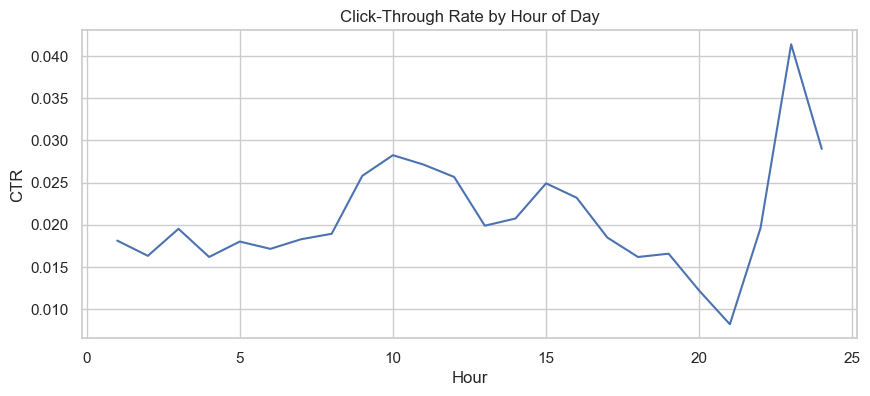

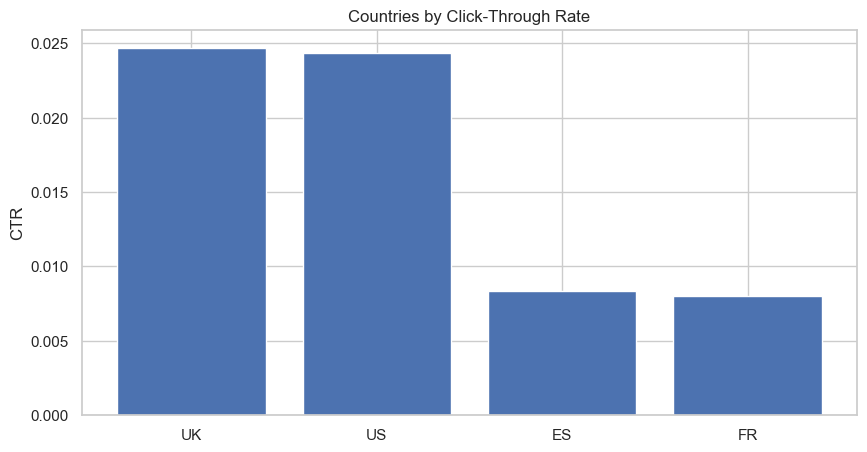

In [38]:

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')

# Hour vs CTR
plt.figure(figsize=(10, 4))
sns.lineplot(x=hour_ctr.index, y=hour_ctr.values)
plt.title('Click-Through Rate by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('CTR')
plt.show()

# Country CTR

plt.figure(figsize=(10, 5))
names = list(country_ctr.keys())
values = list(country_ctr.values())
plt.bar(range(len(country_ctr)), values, tick_label=names)
plt.title('Countries by Click-Through Rate')
plt.ylabel('CTR')
# plt.xticks(rotation=45)
plt.show()


## From above plots, following conclusions and insights can be drawn:
- Late-night hours, especially around `11 PM`, are the most effective for click-based engagement. It may be ideal to schedule campaigns for that time. (This behaviour is quite reasonable as all of us prefer checking mails once in the night before sleep).
- Marketing or advertising efforts are more effective in the `UK and US`.
- Consider tailoring content, targeting, or campaigns differently for `Spain` and `France` to boost performance.